# Recipe Dimensionality Reduction

In this notebook we capture the recipe dimenssionality reduction for the personalization of our user-preference-model. We explore different Natural Language Processing concepts in order to infer recipe closeness in order to punish or reward recipes for the training of the personalization layers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import defaultdict, Counter

import re

## Loading and Inspecting Data

In [12]:
path_to_data_names = '/home/miber/data/cluster_data/df_mod_data_9clust_with_name.csv'
cluster_data_names = pd.read_csv(path_to_data_names)

In [114]:
cluster_data_names.head(100)

,id,minutes,n_steps,n_ingredients,num_days,clean_ingredients__all-purpose flmy,clean_ingredients__allspice,clean_ingredients__almond,clean_ingredients__almond extract,clean_ingredients__american cheese,...,profile_2,profile_3,profile_4,profile_5,profile_6,profile_7,profile_8,name,steps,description
0,137739,55,11,7,4827,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,arriba baked winter squash mexican style,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...
1,31490,30,9,6,6014,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a bit different breakfast pizza,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...
2,112140,130,6,13,5030,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,all in the kitchen chili,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...
3,59389,45,11,11,5713,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,alouette potatoes,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea..."
4,44061,190,5,8,5884,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amish tomato ketchup for canning,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,39363,70,10,11,5936,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the best banana bread or muffins,"['cream together butter and sugar', 'blend in ...","okay, another banana bread recipe...but maybe ..."
96,62368,90,12,10,5680,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the best chocolate chip cheesecake ever,"['preheat oven to 300', 'combine cookie crumbs...",i wrote this recipe down once while visiting a...
97,111875,2,4,4,5031,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,the elvis smoothie,"['place all ingredients in blender', 'blend un...","this is a great smoothie, thick and creamy. my..."
98,42522,40,6,5,5902,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,the man s taco dip,['mix cream cheese and sour cream until a soft...,this a wonderful hot dip for chips that seems ...


In [5]:
cluster_data_names.columns[-40:]

Index(['tag__tex-mex', 'tag__thai', 'tag__thanksgiving', 'tag__tilapia',
       'tag__to-go', 'tag__toddler-friendly', 'tag__tomatoes',
       'tag__tropical-fruit', 'tag__tuna', 'tag__turkey', 'tag__turkish',
       'tag__valentines-day', 'tag__veal', 'tag__vegan', 'tag__vegetables',
       'tag__vegetarian', 'tag__very-low-carbs', 'tag__vietnamese',
       'tag__water-bath', 'tag__weeknight', 'tag__whole-chicken',
       'tag__whole-turkey', 'tag__winter', 'tag__yams-sweet-potatoes',
       'tag__yeast', 'recipe_id_x', 'rating', 'recipe_id_y', 'profile_0',
       'profile_1', 'profile_2', 'profile_3', 'profile_4', 'profile_5',
       'profile_6', 'profile_7', 'profile_8', 'name', 'steps', 'description'],
      dtype='object')

In [6]:
remove_columns = ['id', 'recipe_id_x', 'rating', 'recipe_id_y', 'profile_0',
                  'profile_1', 'profile_2', 'profile_3', 'profile_4', 'profile_5',
                  'profile_6', 'profile_7', 'profile_8']

cluster_data_names_rm = cluster_data_names.drop(columns=remove_columns)

In [7]:
cluster_data_names_rm.columns

Index(['minutes', 'n_steps', 'n_ingredients', 'num_days',
       'clean_ingredients__all-purpose flmy', 'clean_ingredients__allspice',
       'clean_ingredients__almond', 'clean_ingredients__almond extract',
       'clean_ingredients__american cheese', 'clean_ingredients__apple',
       ...
       'tag__water-bath', 'tag__weeknight', 'tag__whole-chicken',
       'tag__whole-turkey', 'tag__winter', 'tag__yams-sweet-potatoes',
       'tag__yeast', 'name', 'steps', 'description'],
      dtype='object', length=790)

## Experiment 1: Projection based on Step Data

**Assumption**: Recipes are similar if they are similar in their step to produce the dish

In [8]:
cluster_ingredients = cluster_data_names_rm['steps']

In [61]:
cluster_ingredients.head()

0    ['make a choice and proceed with recipe', 'dep...
1    ['preheat oven to 425 degrees f', 'press dough...
2    ['brown ground beef in large pot', 'add choppe...
3    ['place potatoes in a large pot of lightly sal...
4    ['mix all ingredients& boil for 2 1 / 2 hours ...
Name: steps, dtype: object

In [29]:
cluster_ingredients[0]

"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']"

In [24]:
type(cluster_ingredients[0])

str

In [131]:
def preprocessor(row, tokenizer = TreebankWordTokenizer(), stop_words = set(stopwords.words('english'))):
    '''Preprocesses list of steps'''
    
    int_step = ''.join([text.replace('"','').replace("'","").replace('[','').replace(']','') for text in row])
    text = re.sub(' +', ' ', int_step.replace(',','').replace('-', ' ').lstrip()) # removing comma, slash and multiple white spaces
    text = text.lower() # all words are lower case
    text = re.sub("\d", "DG", text)
    tokens = tokenizer.tokenize(text)
    porter = PorterStemmer()
    wnl = WordNetLemmatizer()
    tokens_without_stopwords = [wnl.lemmatize(w) if wnl.lemmatize(w).endswith('e') else porter.stem(w) 
                                for w in tokens if w not in stop_words]
    
    return tokens_without_stopwords

In [57]:
preprocessor(cluster_ingredients[1])

['preheat',
 'oven',
 'dgdgdg',
 'degree',
 'f',
 'press',
 'dough',
 'bottom',
 'side',
 'dgdg',
 'inch',
 'pizza',
 'pan',
 'bake',
 'DG',
 'minute',
 'set',
 'brown',
 'cut',
 'sausage',
 'small',
 'piece',
 'whisk',
 'egg',
 'milk',
 'bowl',
 'frothi',
 'spoon',
 'sausage',
 'bake',
 'crust',
 'sprinkle',
 'cheese',
 'pour',
 'egg',
 'mixture',
 'slowli',
 'sausage',
 'cheese',
 '&',
 'p',
 'taste',
 'bake',
 'dgdg',
 'dgdg',
 'minute',
 'egg',
 'set',
 'crust',
 'brown']

In [62]:
cluster_ingredients_processed = cluster_ingredients.apply(preprocessor)

In [63]:
cluster_ingredients_processed.head()

0    [make, choice, proceed, recipe, depend, size, ...
1    [preheat, oven, dgdgdg, degree, f, press, doug...
2    [brown, ground, beef, large, pot, add, chop, o...
3    [place, potato, large, pot, lightli, salt, wat...
4    [mix, ingredi, &, boil, DG, DG, /, DG, hour, t...
Name: steps, dtype: object

In [64]:
cluster_ingredients_processed.to_csv('processed_data.txt', sep=',', index=False, header=False)

In [143]:
class Vocabulary(object):

    START_TOKEN = u"<s>"
    END_TOKEN   = u"</s>"
    UNK_TOKEN   = u"<unk>"
    PAD_TOKEN   = u"<pad>"

    def __init__(self, tokens, size=None,
                 progressbar=lambda l:l):
        """Create a Vocabulary object.
        Args:
            tokens: iterator( string )
            size: None for unlimited, or int > 0 for a fixed-size vocab.
                  Vocabulary size includes special tokens <s>, </s>, <pad> and <unk>
            progressbar: (optional) progress bar to wrap iterator.
        """
        self.unigram_counts = Counter()
        self.bigram_counts = defaultdict(lambda: Counter())
        prev_word = None
        for word in progressbar(tokens):  # Make a single pass through tokens
            self.unigram_counts[word] += 1
            self.bigram_counts[prev_word][word] += 1
            prev_word = word
        self.bigram_counts.default_factory = None  # make into a normal dict

        # Leave space for "<s>", "</s>", <pad> and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 4))
        vocab = ([self.PAD_TOKEN, self.UNK_TOKEN, self.START_TOKEN, self.END_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]
        self.PAD_ID = self.word_to_id[self.PAD_TOKEN]

    @property
    def num_unigrams(self):
        return len(self.unigram_counts)

    @property
    def num_bigrams(self):
        return len(self.bigram_counts)

    def __contains__(self, key):
        if isinstance(key, int):
            return (key > 0 and key < self.size)
        else:
            return key in self.word_to_id

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def pad_sentence(self, words, use_eos=True):
        ret = [self.START_TOKEN] + words
        if use_eos:
            ret.append(self.END_TOKEN)
        return ret

    def sentence_to_ids(self, words, use_eos=True):
        return self.words_to_ids(self.pad_sentence(words, use_eos))

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))

    def write_flat_file(self, filename):
        """Write the vocabulary list to a flat file."""
        ordered_words = self.ids_to_words(range(self.size))
        with open(filename, 'w') as fd:
            for word in ordered_words:
                fd.write(word + "\n")
        print("Vocabulary ({:,} words) written to '{:s}'".format(len(ordered_words),
                                                               filename))

    def write_projector_config(self, checkpoint_dir, tensor_name):
        """Write metadata for TensorBoard Embeddings Projector."""
        import os
        if not os.path.isdir(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        metadata_file = os.path.join(checkpoint_dir, "metadata.tsv")
        self.write_flat_file(metadata_file)
        # Write projector config pb
        projector_config_file = os.path.join(checkpoint_dir,
                                             "projector_config.pbtxt")
        with open(projector_config_file, 'w') as fd:
            contents = """embeddings {
              tensor_name: "%s"
              metadata_path: "metadata.tsv"
            }""" % tensor_name
            fd.write(contents)
        print("Projector config written to {:s}".format(projector_config_file))


In [103]:
vocab = Vocabulary([w for i, l in cluster_ingredients_processed.items() for w in l])

In [104]:
vocab.PAD_TOKEN

'<pad>'

In [144]:
def transform_to_vector(row, vocab=vocab, size=100):
    
    if len(row) < (size-2): # start and end token are included in size
        row = vocab.pad_sentence(row)
        add_pad = size - len(row)
        pad = add_pad * [vocab.PAD_TOKEN]
        row += pad
    else:
        row = row[:(size-3)]
        row = vocab.pad_sentence(row)
        
    return np.asarray(vocab.words_to_ids(row))

NameError: name 'vocab' is not defined

In [106]:
cluster_ingredients_vectors = cluster_ingredients_processed.apply(transform_to_vector)

In [107]:
cluster_ingredients_vectors.head()

0    [2, 72, 679, 1363, 400, 531, 191, 454, 53, 75,...
1    [2, 57, 19, 41, 66, 203, 172, 68, 121, 50, 7, ...
2    [2, 33, 240, 139, 25, 98, 6, 91, 28, 240, 139,...
3    [2, 16, 74, 25, 98, 92, 17, 24, 73, 1059, 43, ...
4    [2, 12, 38, 119, 43, 4, 4, 18, 4, 47, 142, 44,...
Name: steps, dtype: object

In [108]:
vocab.ids_to_words(cluster_ingredients_vectors.iloc[0])

['<s>',
 'make',
 'choice',
 'proceed',
 'recipe',
 'depend',
 'size',
 'squash',
 'cut',
 'half',
 'fourth',
 'remove',
 'seed',
 'spici',
 'squash',
 'drizzle',
 'olive',
 'oil',
 'melt',
 'butter',
 'cut',
 'squash',
 'piece',
 'season',
 'mexican',
 'season',
 'mix',
 'ii',
 'sweet',
 'squash',
 'drizzle',
 'melt',
 'honey',
 'butter',
 'grate',
 'piloncillo',
 'cut',
 'squash',
 'piece',
 'season',
 'sweet',
 'mexican',
 'spice',
 'mix',
 'bake',
 'dgdgdg',
 'degree',
 'depend',
 'size',
 'dgdg',
 'minute',
 'hour',
 'fork',
 'easili',
 'pierce',
 'skin',
 'care',
 'burn',
 'squash',
 'especi',
 'opt',
 'use',
 'sugar',
 'butter',
 'feel',
 'comfortable',
 'cover',
 'squash',
 'aluminum',
 'foil',
 'first',
 'half',
 'hour',
 'give',
 'take',
 'bake',
 'desir',
 'season',
 'salt',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<p

In [110]:
cluster_ingredients_vectors = cluster_ingredients_vectors.apply(pd.Series)

In [111]:
cluster_ingredients_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.0,72.0,679.0,1363.0,400.0,531.0,191.0,454.0,53.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,57.0,19.0,41.0,66.0,203.0,172.0,68.0,121.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,33.0,240.0,139.0,25.0,98.0,6.0,91.0,28.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,16.0,74.0,25.0,98.0,92.0,17.0,24.0,73.0,1059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,12.0,38.0,119.0,43.0,4.0,4.0,18.0,4.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
names = cluster_data_names['id'].tolist()
names[:5]

[137739, 31490, 112140, 59389, 44061]

In [113]:
cluster_ingredients_vectors.index = names

In [114]:
cluster_ingredients_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
137739,2.0,72.0,679.0,1363.0,400.0,531.0,191.0,454.0,53.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31490,2.0,57.0,19.0,41.0,66.0,203.0,172.0,68.0,121.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112140,2.0,33.0,240.0,139.0,25.0,98.0,6.0,91.0,28.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59389,2.0,16.0,74.0,25.0,98.0,92.0,17.0,24.0,73.0,1059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44061,2.0,12.0,38.0,119.0,43.0,4.0,4.0,18.0,4.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
cluster_ingredients_vectors = cluster_ingredients_vectors.fillna(1) # unknown token

In [120]:
cluster_ingredients_vectors.to_csv('processed_data_vectors.txt', sep=',', index=True, header=False)

In [3]:
cluster_ingredients_vectors = pd.read_csv('processed_data_vectors.txt', header=None, index_col=0)

In [4]:
cluster_ingredients_vectors.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
137739,2.0,72.0,679.0,1363.0,400.0,531.0,191.0,454.0,53.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31490,2.0,57.0,19.0,41.0,66.0,203.0,172.0,68.0,121.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112140,2.0,33.0,240.0,139.0,25.0,98.0,6.0,91.0,28.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59389,2.0,16.0,74.0,25.0,98.0,92.0,17.0,24.0,73.0,1059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44061,2.0,12.0,38.0,119.0,43.0,4.0,4.0,18.0,4.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PCA

In [98]:
pca = PCA(n_components=3)
pca.fit(cluster_ingredients_vectors)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.03841087 0.02286641 0.01860648]
0.07988376349708523
[775083.12583723 598026.1683853  539452.61784026]


In [99]:
cluster_ingredients_reduced_pca = pca.fit_transform(cluster_ingredients_vectors)

In [100]:
cluster_ingredients_reduced_pca

array([[ 2.94272751e+03, -1.60604907e+00, -7.02420949e+02],
       [-8.80281050e+02, -1.97488939e+02, -4.68175903e+02],
       [-9.05596938e+02,  3.58138268e+02, -8.97559559e+01],
       ...,
       [-1.23280614e+03,  1.87629285e+02,  4.29333104e+02],
       [ 7.68592928e+02, -4.81545332e+02, -2.11033205e+02],
       [-1.43586040e+03, -2.81393381e+02,  1.48989814e+01]])

In [101]:
cluster_ingredients_reduced_pca[0]

array([ 2.94272751e+03, -1.60604907e+00, -7.02420949e+02])

In [102]:
cluster_ingredients_reduced_pca[1]

array([-880.28105005, -197.48893868, -468.17590307])

In [103]:
euclidean_distances(cluster_ingredients_reduced_pca[0].reshape(1, -1), cluster_ingredients_reduced_pca[1].reshape(1, -1))[0][0]

3835.183864236595

In [104]:
ids = cluster_data_names['id']

In [105]:
ids[:10]

0    137739
1     31490
2    112140
3     59389
4     44061
5      5289
6     25274
7     67888
8     70971
9     75452
Name: id, dtype: int64

In [106]:
len(ids)

231637

In [253]:
from sklearn.neighbors import DistanceMetric
import numpy as np

cluster_ingredients_id = np.loadtxt('recipe_ids.csv', delimiter=',').astype('int')
cluster_ingredients_reduced_pca = np.loadtxt('recipe_pca_projection.csv', delimiter=',')

def get_distances(recipe_id,
                  closest=10,
                  recipe_pca_vec=cluster_ingredients_reduced_pca, 
                  recipe_id_vec=cluster_ingredients_id,
                  metric='euclidean'):
    
    '''Function to calculate distance vector for a given recipe id'''
    
    dist = DistanceMetric.get_metric(metric)
    try:
        index = list(recipe_id_vec).index(recipe_id)
        result = dist.pairwise(recipe_pca_vec[index].reshape(1,-1),recipe_pca_vec)
        closest_ids = np.argsort(result[0])
        max_value = np.max(result[0])
        return zip(list(recipe_id_vec[closest_ids][:closest]),
                   list(result[0][closest_ids][:closest]),
                   list(result[0][closest_ids][:closest]/max_value))
    
    except ValueError:
        print(recipe_id, 'not in recipe id list!')
    

In [254]:
for i, j, k in get_distances(62368):
    print(i, j, k)

62368 0.0 0.0
145896 0.0033957540558906154 3.8952153989882114e-05
190273 0.007262770152190598 8.331007979523726e-05
160304 0.010226000318503842 0.00011730082112865954
151218 0.014099542815255165 0.0001617336102342408
32533 0.018365316227020506 0.00021066561770185724
293539 0.022787619057980008 0.0002613931492092141
402421 0.0228786887932327 0.0002624377956391365
147771 0.026233019648154714 0.0003009147906874917
248680 0.030722104129662635 0.00035240836387308733


In [122]:
from sklearn.neighbors import DistanceMetric

def get_distances(recipe_id,
                  closest=100,
                  recipe_pca_vec=cluster_ingredients_reduced_pca, 
                  recipe_id_vec=cluster_ingredients_id,
                  recipe_name=cluster_data_names['name'],
                  metric='euclidean'):
    
    '''Function to calculate distance vector for a given recipe id'''
    
    dist = DistanceMetric.get_metric(metric)
    try:
        index = list(recipe_id_vec).index(recipe_id)
        result = dist.pairwise(recipe_pca_vec[index].reshape(1,-1),recipe_pca_vec)
        closest_ids = np.argsort(result[0])
        max_value = np.max(result[0])
        return zip(list(recipe_id_vec[closest_ids][:closest]),
                   list(recipe_name[closest_ids][:closest]),
                   list(result[0][closest_ids][:closest]),
                   list(result[0][closest_ids][:closest]/max_value))
    
    except ValueError:
        print(recipe_id, 'not in recipe id list!')
    

In [126]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
89530      | pesto torte                                                            | 70.77      | 0.05%
213997     | seared pork chops with fresh basil and sun dried tomatoes              | 105.98     | 0.08%
408982     | grammy callahan s baked beans                                          | 115.12     | 0.08%
483362     | gougre bourguignonne   cheesy bread pastry from burgundy               | 134.34     | 0.1 %
141570     | frchtebrot mit backobst  fruit bread w  mixed dried fruit              | 144.03     | 0.1 %
26257      | so it s bekah s pulled pork now                                        | 150.56     | 0.11%
275919     | mexican s

### t-SNE

In [112]:
cluster_ingredients_reduced_tsne = TSNE(n_components=3).fit_transform(cluster_ingredients_vectors)

In [127]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368, recipe_pca_vec=cluster_ingredients_reduced_tsne):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
160830     | world s greatest pita bread                                            | 0.01       | 0.01%
283498     | lemon love cake  sandra lee                                            | 0.02       | 0.04%
469501     | banger boxty                                                           | 0.02       | 0.05%
340404     | 45 minute roast turkey  mark bittman                                   | 0.03       | 0.07%
140002     | bbq pulled pork sandwiches   sloooow cooked in your crock pot          | 0.04       | 0.09%
105592     | christmas fudge wreath   rachael ray                                   | 0.04       | 0.1 %
187794     | coconut s

### Without Dimensionality Reduction

In [129]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368, recipe_pca_vec=np.asarray(cluster_ingredients_vectors)):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
187794     | coconut shrimp with sweet chili lime sauce                             | 5069.79    | 3.04%
258199     | oatmeal nut chocolate cookies                                          | 5347.57    | 3.2 %
4533       | apple country chicken                                                  | 5652.39    | 3.39%
160830     | world s greatest pita bread                                            | 5800.89    | 3.48%
65686      | linguini with raisins  pine nuts and bread crumbs                      | 5824.15    | 3.49%
148567     | radicchio flatbread                                                    | 6307.5     | 3.78%
355428     | bay scall

In [223]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(39363, recipe_pca_vec=np.asarray(cluster_ingredients_vectors)):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
39363      | the best  banana bread  or muffins                                     | 0.0        | 0.0 %
501763     | spicy thai peanut vegetable curry                                      | 1247.75    | 0.75%
252372     | ww 2 points   hash browns                                              | 1253.42    | 0.76%
317044     | panko tilapia                                                          | 1354.33    | 0.82%
118537     | chicken with  raspberry  cream sauce                                   | 1369.9     | 0.83%
125197     | roasted vegetable spread                                               | 1382.06    | 0.84%
180789     | fettuccine with creamy mushroom sauce                                  | 1400.75    | 0.85%
79381      | cheddar s

# Closeness Inferred from Recipe Names

In [133]:
def name_preprocessor(row, tokenizer = TreebankWordTokenizer(), stop_words = set(stopwords.words('english'))):
    '''Preprocesses column of names'''

    text = re.sub(' +', ' ', row.replace(',','').replace('-', ' ').lstrip()) # removing comma, slash and multiple white spaces
    text = text.lower() # all words are lower case
    text = re.sub("\d", "DG", text)
    tokens = tokenizer.tokenize(text)
    porter = PorterStemmer()
    wnl = WordNetLemmatizer()
    tokens_without_stopwords = [wnl.lemmatize(w) if wnl.lemmatize(w).endswith('e') else porter.stem(w) 
                                for w in tokens if w not in stop_words]
    
    return tokens_without_stopwords

In [235]:
np.savetxt('recipe_ids.csv', cluster_data_names['id'].values, delimiter=',')

In [140]:
cluster_names = cluster_data_names['name'].astype('str')
cluster_names_processed = cluster_names.apply(name_preprocessor)

In [141]:
cluster_names_processed.head(10)

0    [arriba, bake, winter, squash, mexican, style]
1                   [bit, differ, breakfast, pizza]
2                                  [kitchen, chili]
3                                [alouette, potato]
4                 [amish, tomato, ketchup, canning]
5                         [apple, day, milk, shake]
6                               [aww, marin, olive]
7                   [backyard, style, barbecu, rib]
8                     [banana, DG, ice, cream, pie]
9                             [beat, banana, bread]
Name: name, dtype: object

In [145]:
vocab_names = Vocabulary([w for i, l in cluster_names_processed.items() for w in l])

In [146]:
def transform_to_vector_names(row, vocab=vocab_names, size=8):
    
    if len(row) < (size-2): # start and end token are included in size
        row = vocab.pad_sentence(row)
        add_pad = size - len(row)
        pad = add_pad * [vocab.PAD_TOKEN]
        row += pad
    else:
        row = row[:(size-3)]
        row = vocab.pad_sentence(row)
        
    return np.asarray(vocab.words_to_ids(row))

In [147]:
cluster_name_vectors = cluster_names_processed.apply(transform_to_vector_names).apply(pd.Series)

In [148]:
cluster_name_vectors.head(10)

,0,1,2,3,4,5,6,7
0,2.0,7556.0,12.0,543.0,122.0,108.0,3.0,NaN
1,2.0,1323.0,977.0,124.0,67.0,3.0,0.0,0.0
2,2.0,841.0,54.0,3.0,0.0,0.0,0.0,0.0
3,2.0,3111.0,8.0,3.0,0.0,0.0,0.0,0.0
4,2.0,727.0,20.0,1027.0,1153.0,3.0,0.0,0.0
5,2.0,25.0,418.0,263.0,324.0,3.0,0.0,0.0
6,2.0,9417.0,209.0,147.0,3.0,0.0,0.0,0.0
7,2.0,3940.0,44.0,345.0,180.0,3.0,0.0,0.0
8,2.0,37.0,55.0,86.0,14.0,16.0,3.0,0.0
9,2.0,2854.0,37.0,13.0,3.0,0.0,0.0,0.0


In [149]:
cluster_name_vectors = cluster_name_vectors.fillna(1) # unknown token
cluster_name_vectors.head(10)

,0,1,2,3,4,5,6,7
0,2.0,7556.0,12.0,543.0,122.0,108.0,3.0,1.0
1,2.0,1323.0,977.0,124.0,67.0,3.0,0.0,0.0
2,2.0,841.0,54.0,3.0,0.0,0.0,0.0,0.0
3,2.0,3111.0,8.0,3.0,0.0,0.0,0.0,0.0
4,2.0,727.0,20.0,1027.0,1153.0,3.0,0.0,0.0
5,2.0,25.0,418.0,263.0,324.0,3.0,0.0,0.0
6,2.0,9417.0,209.0,147.0,3.0,0.0,0.0,0.0
7,2.0,3940.0,44.0,345.0,180.0,3.0,0.0,0.0
8,2.0,37.0,55.0,86.0,14.0,16.0,3.0,0.0
9,2.0,2854.0,37.0,13.0,3.0,0.0,0.0,0.0


In [150]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368, recipe_pca_vec=np.asarray(cluster_name_vectors)):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
188927     | carrot cake   fruited carrot loaf or christmas muffins                 | 28.14      | 0.07%
426973     | white chocolate iced blueberry loaf                                    | 28.83      | 0.07%
241786     | white chicken chili best ever                                          | 31.95      | 0.08%
31110      | noodle salad with peanut lime vinaigrette                              | 34.12      | 0.09%
350590     | carrot cake muffins with cheesecake filling  lite                      | 42.41      | 0.11%
406040     | white chocolate cheesecake with fresh berries                          | 42.49      | 0.11%
16873      | ham baked

In [222]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(39363, recipe_pca_vec=np.asarray(cluster_name_vectors)):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
19368      | best banana bread or muffins                                           | 0.0        | 0.0 %
39363      | the best  banana bread  or muffins                                     | 0.0        | 0.0 %
107741     | quick mushroom cream pasta                                             | 9.7        | 0.02%
359685     | herbed green beans and mushrooms                                       | 11.75      | 0.03%
371369     | the best grilled cheese sandwich                                       | 12.04      | 0.03%
274288     | french onion soup grilled cheese                                       | 12.77      | 0.03%
432961     | cinnamon sweet potato fries                                            | 13.96      | 0.04%
298208     | cheesecak

In [152]:
# Source: https://rare-technologies.com/word2vec-tutorial/

tsne = TSNE(n_components=2, random_state=0)
vectors = tsne.fit_transform(cluster_name_vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]
labels = cluster_data_names['name']

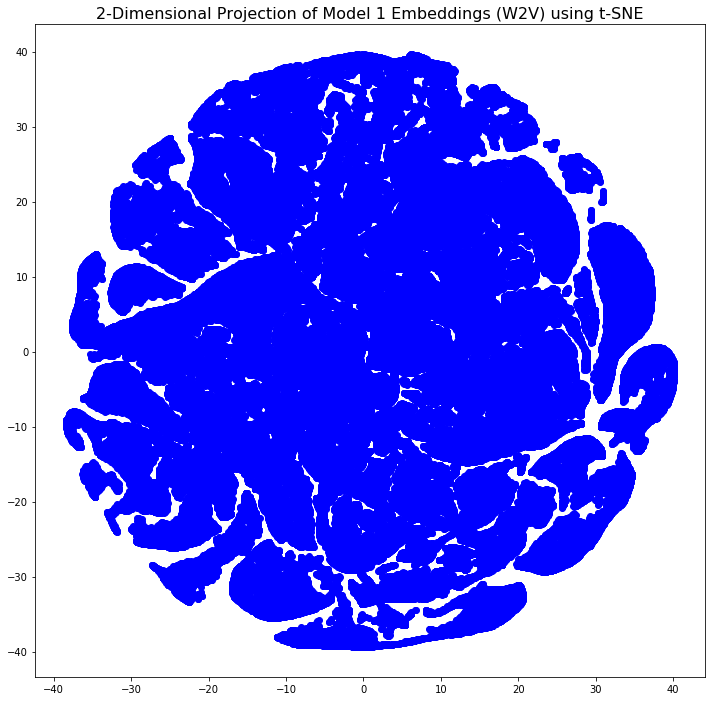

In [153]:
from matplotlib.lines import Line2D
from matplotlib import cm

fig, ax = plt.subplots(figsize=(12, 12))
plt.gca().set_title('2-Dimensional Projection of Model 1 Embeddings (W2V) using t-SNE', fontsize=16)
                         
ax.scatter(x_vals, y_vals, c='blue')

# selected = ['']

# indices = [np.where(labels == i)[0][0] for i in selected]

# for i in indices:
#     ax.annotate(label_pca[i], (x_vals[i], y_vals[i]),fontsize=16, color='darkred')

fig.savefig('recipe_closeness_names.png') 

## Latent Semantic Indexing based on Steps

In [2]:
cluster_ingredients_vectors = pd.read_csv('processed_data_vectors.txt', header=None, index_col=0)

In [3]:
cluster_ingredients_vectors.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
137739,2.0,72.0,679.0,1363.0,400.0,531.0,191.0,454.0,53.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31490,2.0,57.0,19.0,41.0,66.0,203.0,172.0,68.0,121.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112140,2.0,33.0,240.0,139.0,25.0,98.0,6.0,91.0,28.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59389,2.0,16.0,74.0,25.0,98.0,92.0,17.0,24.0,73.0,1059.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44061,2.0,12.0,38.0,119.0,43.0,4.0,4.0,18.0,4.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [216]:
docs = cluster_ingredients_vectors.values
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in docs:
    for term in d:
        index = int(term)
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

In [217]:
sparse_matrix = csr_matrix((data, indices, indptr), dtype=int)

In [218]:
svd = TruncatedSVD(n_components=2)
svd.fit(sparse_matrix)  
sparse_new = svd.fit_transform(sparse_matrix)

In [ ]:
svd.explained_variance_ratio_.sum()

In [224]:
sparse_new

array([[20.15721999,  1.47137435],
       [48.16627573,  1.36309495],
       [59.14899779,  1.34992929],
       ...,
       [73.97886826, -2.67915891],
       [ 3.40136743,  7.49881676],
       [70.062583  , -1.29515891]])

In [225]:
np.savetxt('recipe_pca_projection.csv', sparse_new, delimiter=',')

In [5]:
sparse_new = np.loadtxt('recipe_pca_projection.csv', delimiter=',')

In [6]:
sparse_new

array([[20.15721999,  1.47137435],
       [48.16627573,  1.36309495],
       [59.14899779,  1.34992929],
       ...,
       [73.97886826, -2.67915891],
       [ 3.40136743,  7.49881676],
       [70.062583  , -1.29515891]])

In [226]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
145896     | double ginger pumpkin tart                                             | 0.0        | 0.0 %
190273     | salt roasted pears with caramel sauce                                  | 0.01       | 0.01%
160304     | breakfast fried rice                                                   | 0.01       | 0.01%
151218     | kelly s witches stew                                                   | 0.01       | 0.02%
32533      | delta catfish stew                                                     | 0.02       | 0.02%
293539     | beer steamed shrimp with tomato salsa                                  | 0.02       | 0.03%
402421     | almond bu

In [227]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(39363, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
39363      | the best  banana bread  or muffins                                     | 0.0        | 0.0 %
443129     | chicken soup   a gift to comfort a friend                              | 0.01       | 0.02%
332034     | the best vegan pumpkin muffins                                         | 0.01       | 0.02%
332307     | oven baked macaroni and cheese                                         | 0.02       | 0.03%
66076      | mango tomato pasta                                                     | 0.02       | 0.03%
230217     | make ahead cheese strata                                               | 0.02       | 0.03%
462881     | king ranch casserole                                                   | 0.02       | 0.03%
410389     | grandma s

In [228]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(44061, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
44061      | amish  tomato ketchup  for canning                                     | 0.0        | 0.0 %
14533      | erin s orange roasted chicken                                          | 0.01       | 0.02%
10709      | nelle s shepherd s pie                                                 | 0.01       | 0.02%
296901     | summer squash with apple                                               | 0.02       | 0.03%
228705     | malay  marinade for grilled pork                                       | 0.02       | 0.03%
120521     | diced ham dinner starter  oamc                                         | 0.02       | 0.03%
105881     | tex mex couscous                                                       | 0.02       | 0.03%
164456     | unbaked p

In [229]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(112140, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
112140     | all in the kitchen  chili                                              | 0.0        | 0.0 %
218227     | lower carb lemon caper chicken                                         | 0.0        | 0.01%
367479     | orange whipped sweet potatoes                                          | 0.01       | 0.02%
349343     | broccoli and carrots in cream cheese sauce                             | 0.01       | 0.02%
98734      | cheesy chicken   broccoli macaroni                                     | 0.01       | 0.02%
288350     | jack s chardonnay and red lentil soup                                  | 0.01       | 0.02%
97731      | rub tenderizer for london broil                                        | 0.02       | 0.03%
284059     | mexi beef

### This seems to work best!

In [10]:
from sklearn.neighbors import DistanceMetric
import numpy as np

recipe_id = np.asarray(cluster_ingredients_vectors.index)

def get_distances(recipe_id,
                  closest=10,
                  recipe_pca_vec=sparse_new, 
                  recipe_id_vec=recipe_id):
    
    '''Function to calculate distance vector for a given recipe id'''
    
    dist = DistanceMetric.get_metric('euclidean')
    index = list(recipe_id_vec).index(recipe_id)
    result = dist.pairwise(recipe_pca_vec[index].reshape(1,-1),recipe_pca_vec)
    closest_ids = np.argsort(result[0])
    return recipe_id_vec[closest_ids][:closest]
    

In [9]:
np.asarray(cluster_ingredients_vectors.index)

array([137739,  31490, 112140, ..., 308080, 298512, 298509])

In [12]:
len(recipe_id)

231637

In [17]:
result = np.zeros((len(recipe_id), 10))
counter = 0
max_values = len(recipe_id)

for idx in recipe_id:
    result[counter] = get_distances(idx)
    counter += 1
    progress = counter / max_values
    if counter%1000==0:
        print(round(progress*100, 2),'%')

0.43 %
0.86 %
1.3 %
1.73 %
2.16 %
2.59 %
3.02 %
3.45 %
3.89 %
4.32 %
4.75 %
5.18 %
5.61 %
6.04 %
6.48 %
6.91 %
7.34 %
7.77 %
8.2 %
8.63 %
9.07 %
9.5 %
9.93 %
10.36 %
10.79 %
11.22 %
11.66 %
12.09 %
12.52 %
12.95 %
13.38 %
13.81 %
14.25 %
14.68 %
15.11 %
15.54 %
15.97 %
16.4 %
16.84 %
17.27 %
17.7 %
18.13 %
18.56 %
19.0 %
19.43 %
19.86 %
20.29 %
20.72 %
21.15 %
21.59 %
22.02 %
22.45 %
22.88 %
23.31 %
23.74 %
24.18 %
24.61 %
25.04 %
25.47 %
25.9 %
26.33 %
26.77 %
27.2 %
27.63 %
28.06 %
28.49 %
28.92 %
29.36 %
29.79 %
30.22 %
30.65 %
31.08 %
31.51 %
31.95 %
32.38 %
32.81 %
33.24 %
33.67 %
34.11 %
34.54 %
34.97 %
35.4 %
35.83 %
36.26 %
36.7 %
37.13 %
37.56 %
37.99 %
38.42 %
38.85 %
39.29 %
39.72 %
40.15 %
40.58 %
41.01 %
41.44 %
41.88 %
42.31 %
42.74 %
43.17 %
43.6 %
44.03 %
44.47 %
44.9 %
45.33 %
45.76 %
46.19 %
46.62 %
47.06 %
47.49 %
47.92 %
48.35 %
48.78 %
49.21 %
49.65 %
50.08 %
50.51 %
50.94 %
51.37 %
51.81 %
52.24 %
52.67 %
53.1 %
53.53 %
53.96 %
54.4 %
54.83 %
55.26 %
55.69 %
56.12

In [18]:
np.savetxt('recipe_pca_2d_result.csv', result, delimiter=',')

In [19]:
result

array([[137739., 431019.,  66075., ..., 299951., 320393., 484186.],
       [ 31490.,  30917., 277603., ...,  72154., 186294., 257321.],
       [112140., 218227., 367479., ..., 284059., 324130., 206446.],
       ...,
       [308080., 236889., 213941., ...,  73900., 320558., 341602.],
       [298512., 317899., 120819., ..., 305899.,  85281., 376414.],
       [298509., 247235., 164626., ..., 258828.,  59912., 378188.]])

## Latent Semantic Indexing based on Names

In [207]:
cluster_name_vectors

,0,1,2,3,4,5,6,7
0,2.0,7556.0,12.0,543.0,122.0,108.0,3.0,1.0
1,2.0,1323.0,977.0,124.0,67.0,3.0,0.0,0.0
2,2.0,841.0,54.0,3.0,0.0,0.0,0.0,0.0
3,2.0,3111.0,8.0,3.0,0.0,0.0,0.0,0.0
4,2.0,727.0,20.0,1027.0,1153.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...
231632,2.0,4588.0,11.0,3.0,0.0,0.0,0.0,0.0
231633,2.0,4588.0,72.0,103.0,3.0,0.0,0.0,0.0
231634,2.0,4588.0,1946.0,1946.0,344.0,50.0,3.0,0.0
231635,2.0,18.0,5155.0,18.0,560.0,3.0,0.0,0.0


In [208]:
docs = cluster_name_vectors.values
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in docs:
    for term in d:
        index = int(term)
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

In [209]:
sparse_matrix = csr_matrix((data, indices, indptr), dtype=int)

In [210]:
svd = TruncatedSVD(n_components=2)
svd.fit(sparse_matrix)  
sparse_new = svd.fit_transform(sparse_matrix)

In [211]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(62368, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
62368      | the best  chocolate chip cheesecake ever                               | 0.0        | 0.0 %
457146     | brazilian black bean and beef stew                                     | 0.0        | 0.0 %
17215      | solo green chili cheese omelette                                       | 0.0        | 0.0 %
519533     | soft sour cream sugar cookies                                          | 0.0        | 0.0 %
304818     | halibut with saffron vanilla cream sauce                               | 0.0        | 0.0 %
462582     | reese s peanut butter cups   no bake                                   | 0.0        | 0.0 %
52927      | penne and meatballs with red pepper sauce                              | 0.0        | 0.0 %
401588     | white cho

In [212]:
print('{0: <10} | {1: <70} | {2: <10} | {3: <4}'.format('Recipe ID','Recipe Name','Distance','Closeness % of Maximum'))
print(60*'- ')
for rec, name, distance, closeness in get_distances(39363, recipe_pca_vec=sparse_new):
    print('{0: <10} | {1: <70} | {2: <10} | {3: <4}%'.format(rec, name, round(distance,2), round(closeness*100,2)))

Recipe ID  | Recipe Name                                                            | Distance   | Closeness % of Maximum
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
39363      | the best  banana bread  or muffins                                     | 0.0        | 0.0 %
19368      | best banana bread or muffins                                           | 0.0        | 0.0 %
54060      | pecan pear tossed salad                                                | 0.0        | 0.0 %
452478     | easy sausage pancake casserole                                         | 0.0        | 0.0 %
105679     | salmon salad on the half shell                                         | 0.0        | 0.0 %
35517      | glazed harvest apple cake                                              | 0.0        | 0.0 %
462894     | blackened salmon caesar salad                                          | 0.0        | 0.0 %
381007     | mexi ranc